In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200804112317-0000
KERNEL_ID = 01f9ce39-00c1-46bf-8bc7-c3757a6171da


In [2]:
!pip install watson-transformer

    100% |████████████████████████████████| 225kB 5.8MB/s eta 0:00:01
    100% |████████████████████████████████| 829kB 5.0MB/s eta 0:00:01
    100% |████████████████████████████████| 378kB 6.8MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 3.5MB/s eta 0:00:01
    100% |████████████████████████████████| 6.5MB 2.3MB/s eta 0:00:01
    100% |████████████████████████████████| 552kB 5.8MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 6.0MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 7.2MB/s eta 0:00:01
    100% |████████████████████████████████| 204kB 7.3MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 6.4MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 5.1MB/s eta 0:00:01
    100% |████████████████████████████████| 143kB 7.8MB/s eta 0:00:01
    100% |████████████████████████████████| 163kB 7.5MB/s eta 0:00:01
  Stored in directory: /home/spark/shared/.cache/pip/wheels/89/7d/0a/2ff0215b826ef7d5a5292a62

In [3]:
from watson_transformer import WatsonServiceTransformer, JSONTransformer, FlatColumnTransformer
from watson_transformer.service import STT, NLU
from watson_transformer.contrib.stt import DefaultSTTParser
from watson_transformer.contrib.nlu import DefaultNLUParser
import watson_transformer.contrib.readers as readers
from ibm_watson.natural_language_understanding_v1 import Features, KeywordsOptions, ConceptsOptions, SentimentOptions, EmotionOptions

import json
from ibm_watson import SpeechToTextV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [4]:
import pandas as pd
import time
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline

# Watson Transformer package - STT Workflow
###  Step by step walkthrough to execute Pipeline for STT trancription 

> This notebook uses audio files loaded in the IBM Object Storage.
> To use files loaded directly into the project assets, use [project-lib](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html#fetch-files)
> To use files from a data source connection, [see documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/load-and-access-data.html?audience=wdp#conns)

## [Part 1: Transformers & Services](#pt1)

## [Part 2: Pipeline & Execution](#pt2)


<a id='pt1'></a> 
## Part 1: Transformers & Services 

1. [Load file names to transcribe](#pt1_s1)
    - [Access data in IBM Cloud Object Storage](#pt1_s1a)
    - [Access data in project](#pt1_s1b)
2. [Create reader for IBM Cloud Object Storage](#pt1_s2)
3. [Define Watson Service with credentials & parameters](#pt1_s3)
4. [Initialize Watson Service transformer](#pt1_s4)
5. [Initialize JSON transformer](#pt1_s5)
   

<a id='pt1_s1'></a> 
### 1a. Access list of files 

<a id='pt1_s1a'></a> 
#### 1a. Load file names to transcribe - access data files/keys from IBM COS

In [30]:
# Credentials to cloud object storage

api_key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
auth_endpoint = 'https://iam.ng.bluemix.net/oidc/token'
private_endpoint_url='https://s3.us-south.objectstorage.service.networklayer.com' 
public_endpoint_url='https://s3.us-south.objectstorage.softlayer.net' 
instance_id = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
Bucket ='stt-samples'

In [31]:
# The code was removed by Watson Studio for sharing.

In [32]:
import boto3
import types
from botocore.client import Config
import ibm_boto3

cos_clstorage  = ibm_boto3.resource(service_name='s3',
                               ibm_api_key_id=api_key,
                               ibm_auth_endpoint=auth_endpoint,
                               config=Config(signature_version='oauth'),
                               endpoint_url=public_endpoint_url,
                               ibm_service_instance_id= instance_id)

##### Access IBM COS and retrieve all contents in bucket and return a list with the object names

In [33]:
#Function iterates over IBM COS and appends every object into a list, and then adds them to a dataframe to use later 

def get_bucket_contents(bucket_name):
    files_list=[]
    print("Retrieving bucket contents from: {0}\n...".format(bucket_name))
    try: 
        files = cos_clstorage.Bucket(bucket_name).objects.all()
        for file in files:
            #print("Item: {0} ({1} bytes).".format(file.key, file.size))
            files_list.append(file.key)      
    
    except Exception as e:
        print("Unable to retrieve bucket contents: {0}".format(e))
    print("\nFiles found in bucket: ")
    for i in files_list:
        print(i)
    
    #dataframe with all the available files in the object storage (even call logs)
    bucket_files = pd.DataFrame({'audio_file': files_list})

    return bucket_files

In [34]:
bucket_files = get_bucket_contents(Bucket) #Executing function - returns dataframe 

Retrieving bucket contents from: stt-samples
...

Files found in bucket: 
incomingcall_sample1.mp3
incomingcall_sample2.mp3
incomingcall_sample3 copy 2.mp3
incomingcall_sample3 copy 3.mp3
incomingcall_sample3 copy.mp3
incomingcall_sample3.mp3
incomingcall_sample4 copy 2.mp3
incomingcall_sample4 copy 3.mp3
incomingcall_sample4 copy.mp3
incomingcall_sample4.mp3
outboundcall_sample1.mp3
outboundcall_sample2.mp3
outboundcall_sample3 copy 2.mp3
outboundcall_sample3 copy 3.mp3
outboundcall_sample3 copy.mp3
outboundcall_sample3.mp3
outboundcall_sample4 copy 2.mp3
outboundcall_sample4 copy 3.mp3
outboundcall_sample4 copy.mp3
outboundcall_sample4.mp3


In [35]:
#If you want to select only files of a certain type, can narrow down.. 
mp3_bucket_files = bucket_files[bucket_files['audio_file'].str.contains('mp3')]

print('Number of .mp3 files in bucket: ',mp3_bucket_files.shape[0])

Number of .mp3 files in bucket:  20


In [36]:
#view
mp3_bucket_files.head()

,audio_file
0,incomingcall_sample1.mp3
1,incomingcall_sample2.mp3
2,incomingcall_sample3 copy 2.mp3
3,incomingcall_sample3 copy 3.mp3
4,incomingcall_sample3 copy.mp3


<a id='pt1_s1b'></a> 
#### 1b. Load list of files from project 

In [37]:
mp3_project_files = pd.read_csv(project.get_file('MP3_AudioFiles.csv'), sep=',')
print(mp3_project_files.count())
mp3_project_files.head()

audio_file    20
dtype: int64


,audio_file
0,incomingcall_sample1.mp3
1,incomingcall_sample2.mp3
2,incomingcall_sample3 copy 2.mp3
3,incomingcall_sample3 copy 3.mp3
4,incomingcall_sample3 copy.mp3


<a id='pt1_s2'></a> 
### 2. Create reader for IBM COS
Uses same above credentials

In [38]:
def ibm_cos_reader(audio_file):
    # boto3 is not thread safe
    # issue: https://github.com/boto/botocore/issues/1246
    # ref: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/core/session.html
    # create new session for each thread, boto3 is not thread safe
    session = ibm_boto3.session.Session() 
    cos_client = session.client(service_name='s3',
                                           ibm_api_key_id=api_key,
                                           ibm_auth_endpoint=auth_endpoint,
                                           config=Config(signature_version='oauth'),
                                           endpoint_url=public_endpoint_url)
    audio_stream = cos_client.get_object(Bucket=Bucket, Key=audio_file)['Body'] # hard code filename for testing 
    if not hasattr(audio_stream, "__iter__"): audio_stream.__iter__ = types.MethodType( __iter__, audio_stream)
    return audio_stream


<a id='pt1_s3'></a> 
### 3. Define Watson Service

In [39]:
#STT Credentials 

stt_token = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX" 
stt_endpoint = 'https://stream.watsonplatform.net/speech-to-text/api'

In [40]:
# The code was removed by Watson Studio for sharing.

In [41]:
#defining STT service
stt = STT(token = stt_token,
                   endpoint = stt_endpoint,
                   reader = ibm_cos_reader,
                   model='en-US_ShortForm_NarrowbandModel',
                   inactivity_timeout=-1,
                   profanity_filter=False,
                   max_alternatives=1,
                   split_transcript_at_phrase_end=False,
                   content_type='audio/mp3')

<a id='pt1_s4'></a> 
### 4. Initialize Watson Service Transformer
#### [WatsonServiceTransformer()](https://github.com/kai-niu/watson-transformer/blob/master/src/watson_transformer/watson_service_transformer.py)


##### Returns:
- JSON dumps from API service 

##### Parameters: 
- inputCol: column name with audio file name 
- outputCol: column name for output column
- max_workers: number of workers for each task 
- [Watson Service Class Object](https://github.com/kai-niu/watson-transformer/tree/master/src/watson_transformer/service) (notebook uses [STT](https://github.com/kai-niu/watson-transformer/blob/master/src/watson_transformer/service/stt.py) as example). 
    - Service credentials: API Token & Endpoint URL
    - Object storage reader to retrieve files
    - Service parameters to pass the underlying service constructor (example: see [STT documentation](https://cloud.ibm.com/apidocs/speech-to-text?code=python#recognize-audio))


In [42]:
wt = WatsonServiceTransformer(inputCol='audio_file', 
                               outputCol='stt_response',
                               vectorization=True,
                               max_workers =4,
                               service=stt)


<a id='pt1_s3a'></a> 

> Example of output from Watson Service Transformer (without JSON transformer)
If executed individually, the WatsonServiceTransformer would return a dataframe with the audio file name and one with the JSON output called 'stt_response' as detailed above. This notebook executes the whole pipeline below rather than the separate pieces, but code to execute this piece can be found below if needed for testing. 

In [43]:
#df = spark.createDataFrame(mp3_bucket_files).repartition(5)
#start = time.perf_counter()
#stt_wt = wt.transform(df).toPandas()
#print("time perf: " ,time.perf_counter() - start)

Below is an example of output from WatsonServieTransformer() if executed without the parser. 
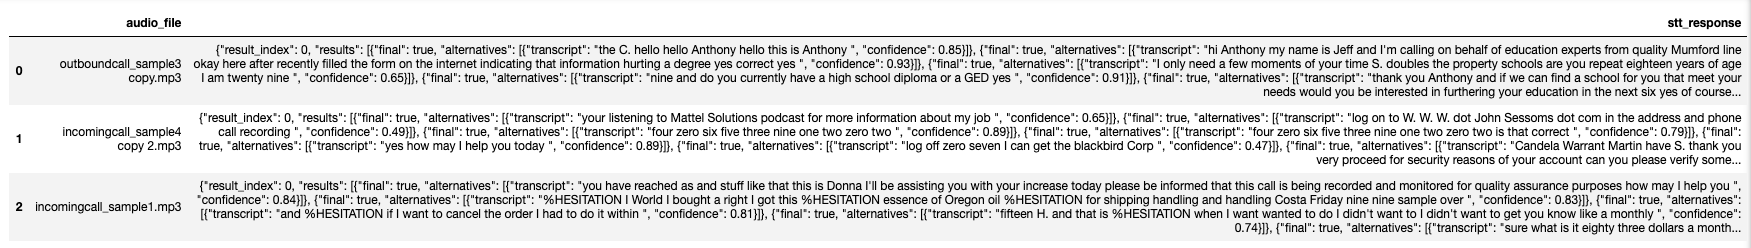

<a id='pt1_s5'></a> 
### 5. Initialize JSON Transformer
#### [JSONTransformer()](https://github.com/kai-niu/watson-transformer/blob/master/src/watson_transformer/json_transformer.py) 

##### Pipeline: Dataframe with JSON response from Watson Transformer -> JSONTransformer() -> Data columns
> JSONTransformer() executes Parser/interpreter to output data from JSON object

##### Returns:
- Dataframe with data columns 

##### Parameters:
- inputCol: column name with json response
- outputCol: column name for data column 
- Parser/Interpreter - Package inlcudes two basic interpreters
    - [DefaultSTTParser()](https://github.com/kai-niu/watson-transformer/blob/master/src/watson_transformer/contrib/stt/default_stt_parser.py) - used in this notebook as example
    - Also available [DefaultNLUParser()](https://github.com/kai-niu/watson-transformer/blob/master/src/watson_transformer/contrib/nlu/default_nlu_parser.py)
    - Both interpreters have limitations - for example, DefaultSTTParser() assumes one alternative transcript and no speaker detection
    - Can create own parser if more detail needed 

In [44]:
### Initialize transformer with Parser 
jt_stt = JSONTransformer(inputCol='stt_response',
                     outputCol='transcript',
                     removeInputCol=False,
                     parser = DefaultSTTParser())


<a id='pt2'></a> 

## Part 2: Pipeline & Execution
1. [Create PySpark DataFrame](#pt2_s1)
2. [Create & execute pipeline](#pt2_s2)
3. [Save output to project](#pt2_s3)

<a id='pt2_s1'></a> 
### 1. Create PySpark DataFrame 

Put audio_files into a PySpark dataframe and repartition using repartition() to distribute work across nodes. Spark will try to evenly distribute the data to each partitioN. When processing, Spark assigns one task for each partition and each worker can only process one task at a time. Thus, if number of partitions is too low, then not all cores in the cluster will be occupied - causing a data skewing problem. With too many partitions, it will bring overhead for Spark to manage too many small tasks.

- When processing, Spark assigns one task per partition - each worker can only process one task at a time. Thus,
    - If number of partitions is too small (if there are less partitions than workers): improper resource utilization
    - If number of partitions is too big 
    - If there are more partitions than records, some partitions will be empty. 


If unsure on number of partitions: The general rule of thumb for Spark says that number of partitions should be 3-4 times the number of cores for CPU bounded jobs. In our case, STT is an IO bounded job and moreover the length of recordings being transcribed will likely differ. To use all cores efficiently, we suggest you decide the number of partitions based on the size of the input and number of worker nodes:
- partitions = (size of input)/(max_workers) e.g.: 10K files when using max_workers=20 -> 10K/20 = 500 partitions
- Make sure the number of partitions is greater or equal to the number of cores 

In [48]:
### testing 2 executors with 2vcpus 8gb ram = 1 core per worker 
### just 20 files 
#### 20 files / 4 workers = 5 partitions
df = spark.createDataFrame(mp3_bucket_files).repartition(5)

print(df.rdd.getNumPartitions())

5


<a id='pt2_s2'></a> 
### 2. Create & execute pipeline

#### Create pipeline 
- First part will execute watson transformer service (outputs json response from STT)
- Second part will take output from the wt function and will use as input to jt_stt
- jt_stt Transformer will take JSON data and turn it into the parser's output format 

In [49]:
pipeline_stt = Pipeline(stages=[wt, jt_stt])

#### Fit pipeline on PySpark DataFrame

In [50]:
fp_stt = pipeline_stt.fit(df)
fp_stt.transform(df).explain()

== Physical Plan ==
*(2) Project [audio_file#37, stt_response#40, pythonUDF0#49 AS transcript#44]
+- BatchEvalPython [DefaultSTTParser(stt_response#40)], [audio_file#37, stt_response#40, pythonUDF0#49]
   +- *(1) Project [audio_file#37, pythonUDF0#48 AS stt_response#40]
      +- ArrowEvalPython [vectorized_udf(audio_file#37)], [audio_file#37, pythonUDF0#48]
         +- Exchange RoundRobinPartitioning(5)
            +- Scan ExistingRDD[audio_file#37]


#### Perform transform on PySpark dataframe: 
.transform(pysparkdf)

In [51]:
start = time.perf_counter()
transcription_df = fp_stt.transform(df).toPandas()
print("time perf: " ,time.perf_counter() - start)

time perf:  643.8081022140104


In [54]:
pd.set_option('max_colwidth',1000)
transcription_df

,audio_file,stt_response,transcript
0,incomingcall_sample4 copy 2.mp3,"{""result_index"": 0, ""results"": [{""final"": true, ""alternatives"": [{""transcript"": ""your listening to Mattel Solutions podcast for more information about my job "", ""confidence"": 0.65}]}, {""final"": true, ""alternatives"": [{""transcript"": ""log on to W. W. W. dot John Sessoms dot com in the address and phone call recording "", ""confidence"": 0.49}]}, {""final"": true, ""alternatives"": [{""transcript"": ""four zero six five three nine one two zero two "", ""confidence"": 0.89}]}, {""final"": true, ""alternatives"": [{""transcript"": ""four zero six five three nine one two zero two is that correct "", ""confidence"": 0.79}]}, {""final"": true, ""alternatives"": [{""transcript"": ""yes how may I help you today "", ""confidence"": 0.89}]}, {""final"": true, ""alternatives"": [{""transcript"": ""log off zero seven I can get the blackbird Corp "", ""confidence"": 0.47}]}, {""final"": true, ""alternatives"": [{""transcript"": ""Candela Warrant Martin have S. thank you very proceed for security reasons of your account can you please verify some...",your listening to Mattel Solutions podcast for more information about my job. log on to W. W. W. dot John Sessoms dot com in the address and phone call recording. four zero six five three nine one two zero two. four zero six five three nine one two zero two is that correct. yes how may I help you today. log off zero seven I can get the blackbird Corp. Candela Warrant Martin have S. thank you very proceed for security reasons of your account can you please verify some information for me first. yep can have the first and last name of the account holder. your million. K.. Angelo my C. Hewitt today finance. R. I. canister Al Milligan can you please verify the billing zip code. five nine seven one four. and also the last four digits of your social security number. five four three thanks very much for that information just to make Platonist Centrale Yusti V. letter regarding his locker torch and you want to take advantage of this offer. yes ok Martin have this issue that I V. filling out...
1,outboundcall_sample3.mp3,"{""result_index"": 0, ""results"": [{""final"": true, ""alternatives"": [{""transcript"": ""the C. hello hello Anthony hello this is Anthony "", ""confidence"": 0.85}]}, {""final"": true, ""alternatives"": [{""transcript"": ""hi Anthony my name is Jeff and I'm calling on behalf of education experts from quality Mumford line okay here after recently filled the form on the internet indicating that information hurting a degree yes correct yes "", ""confidence"": 0.93}]}, {""final"": true, ""alternatives"": [{""transcript"": ""I only need a few moments of your time S. doubles the property schools are you repeat eighteen years of age I am twenty nine "", ""confidence"": 0.65}]}, {""final"": true, ""alternatives"": [{""transcript"": ""nine and do you currently have a high school diploma or a GED yes "", ""confidence"": 0.91}]}, {""final"": true, ""alternatives"": [{""transcript"": ""thank you Anthony and if we can find a school for you that meet your needs would you be interested in furthering your education in the next six yes of course...",the C. hello hello Anthony hello this is Anthony. hi Anthony my name is Jeff and I'm calling on behalf of education experts from quality Mumford line okay here after recently filled the form on the internet indicating that information hurting a degree yes correct yes. I only need a few moments of your time S. doubles the property schools are you repeat eighteen years of age I am twenty nine. nine and do you currently have a high school diploma or a GED yes. thank you Anthony and if we can find a school for you that meet your needs would you be interested in furthering your education in the next six yes of course on the course I'd like to take up would be computer engineering. Jr Hey. and three. I only yeah. fine ok. could you verify your information your first name's

<a id='pt2_s3'></a> 
### 3. Save dataframe as csv file in WS project

In [55]:
project.save_data('SampleTranscriptions_Workflow.csv', transcription_df.to_csv(index=False, sep='|'), overwrite=True)

{'file_name': 'SampleTranscriptions_Workflow.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'audioworkflow-donotdelete-pr-yrglph8ci3mfxo',
 'asset_id': 'af65af0f-dc83-4182-8ad2-d15863dd7baf'}